In [2]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
from scipy import stats

# For reproducibility of plots
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Define the tickers and date range
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date = '2025-07-31'

# Download the data
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

# Save to CSV for future use
data.to_csv('../data/raw/portfolio_data_2015_2025.csv')

# Display the first few rows
print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed

Ticker           TSLA                                                    BND  \
Price            Open       High        Low      Close     Volume       Open   
Date                                                                           
2015-07-01  18.073999  18.174667  17.856667  17.943333   31518000  60.794183   
2015-07-02  18.680000  18.830000  18.220667  18.667999  107458500  60.937024   
2015-07-06  18.591999  18.779333  18.420000  18.648001   61828500  61.222695   
2015-07-07  18.333332  18.346666  17.384666  17.858667   91576500  61.410611   
2015-07-08  17.288000  17.386667  16.954000  16.997334   93316500  61.373039   

Ticker                                                       SPY              \
Price            High        Low      Close   Volume        Open        High   
Date                                                                           
2015-07-01  60.914460  60.764112  60.816734  5399300  175.110995  175.363889   
2015-07-02  61.027236  60.937024  60.96

2.  Data Cleaning and Understanding

In [4]:
# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())



Missing values per column:
Ticker  Price 
TSLA    Open      0
        High      0
        Low       0
        Close     0
        Volume    0
BND     Open      0
        High      0
        Low       0
        Close     0
        Volume    0
SPY     Open      0
        High      0
        Low       0
        Close     0
        Volume    0
dtype: int64


In [6]:
# Check data types
print("\nData types:")
print(data.dtypes)

# Basic statistics for closing prices
print("\nDescriptive statistics for closing prices:")
closing_prices = data.xs('Close', level=1, axis=1)
print(closing_prices.describe())


Data types:
Ticker  Price 
TSLA    Open      float64
        High      float64
        Low       float64
        Close     float64
        Volume      int64
BND     Open      float64
        High      float64
        Low       float64
        Close     float64
        Volume      int64
SPY     Open      float64
        High      float64
        Low       float64
        Close     float64
        Volume      int64
dtype: object

Descriptive statistics for closing prices:
Ticker         TSLA          BND          SPY
count   2535.000000  2535.000000  2535.000000
mean     131.963002    68.469188   334.193733
std      120.914904     4.554601   126.427703
min        9.578000    60.779156   155.869751
25%       18.967667    64.654350   230.083183
50%       94.571335    67.604858   305.264404
75%      236.761665    71.891129   420.350510
max      479.859985    77.318245   637.099976


3. Exploratory Data Analysis (EDA)

Closing Prices Trend

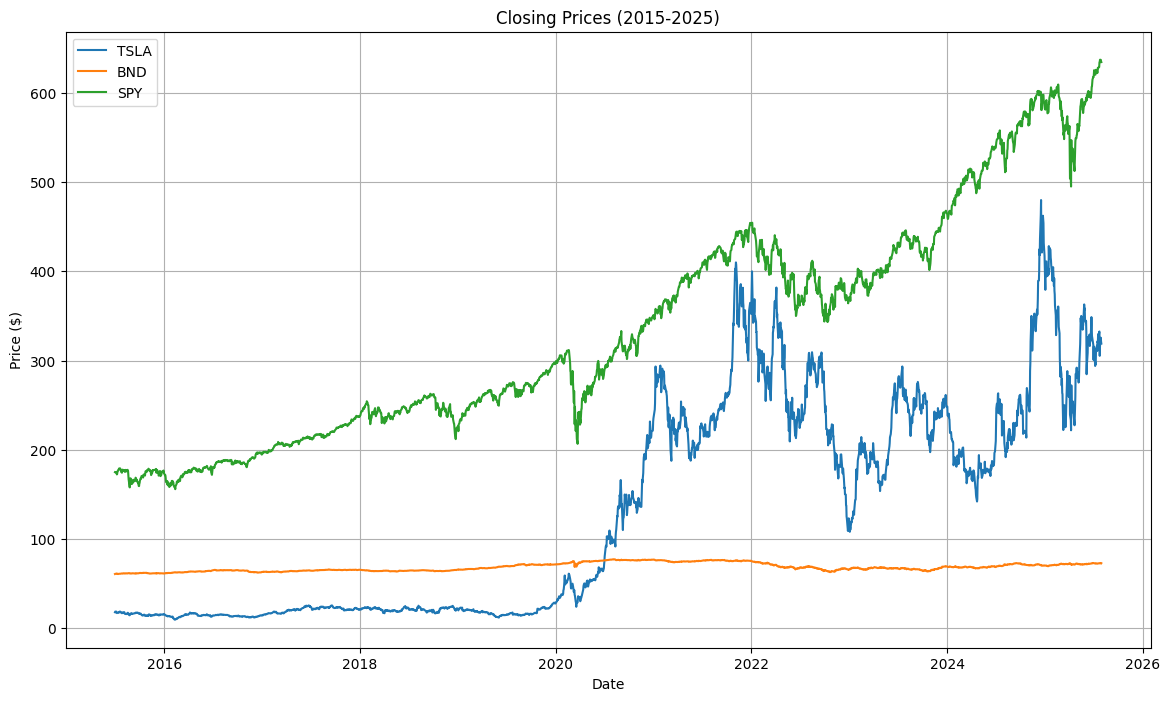

In [7]:
# Plot closing prices
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(closing_prices[ticker], label=ticker)
    
plt.title('Closing Prices (2015-2025)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

Daily Percentage Returns

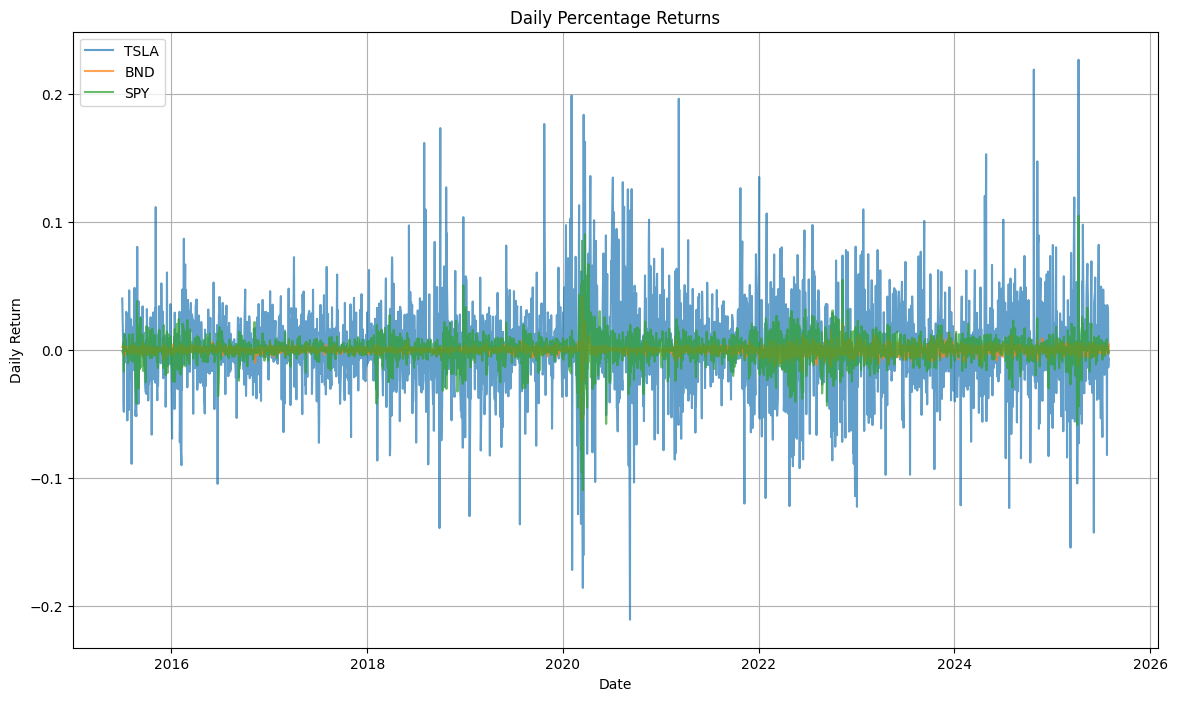

In [8]:
# Calculate daily returns
daily_returns = closing_prices.pct_change().dropna()

# Plot daily returns
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(daily_returns[ticker], label=ticker, alpha=0.7)
    
plt.title('Daily Percentage Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.show()

Volatility Analysis (Rolling Metrics)

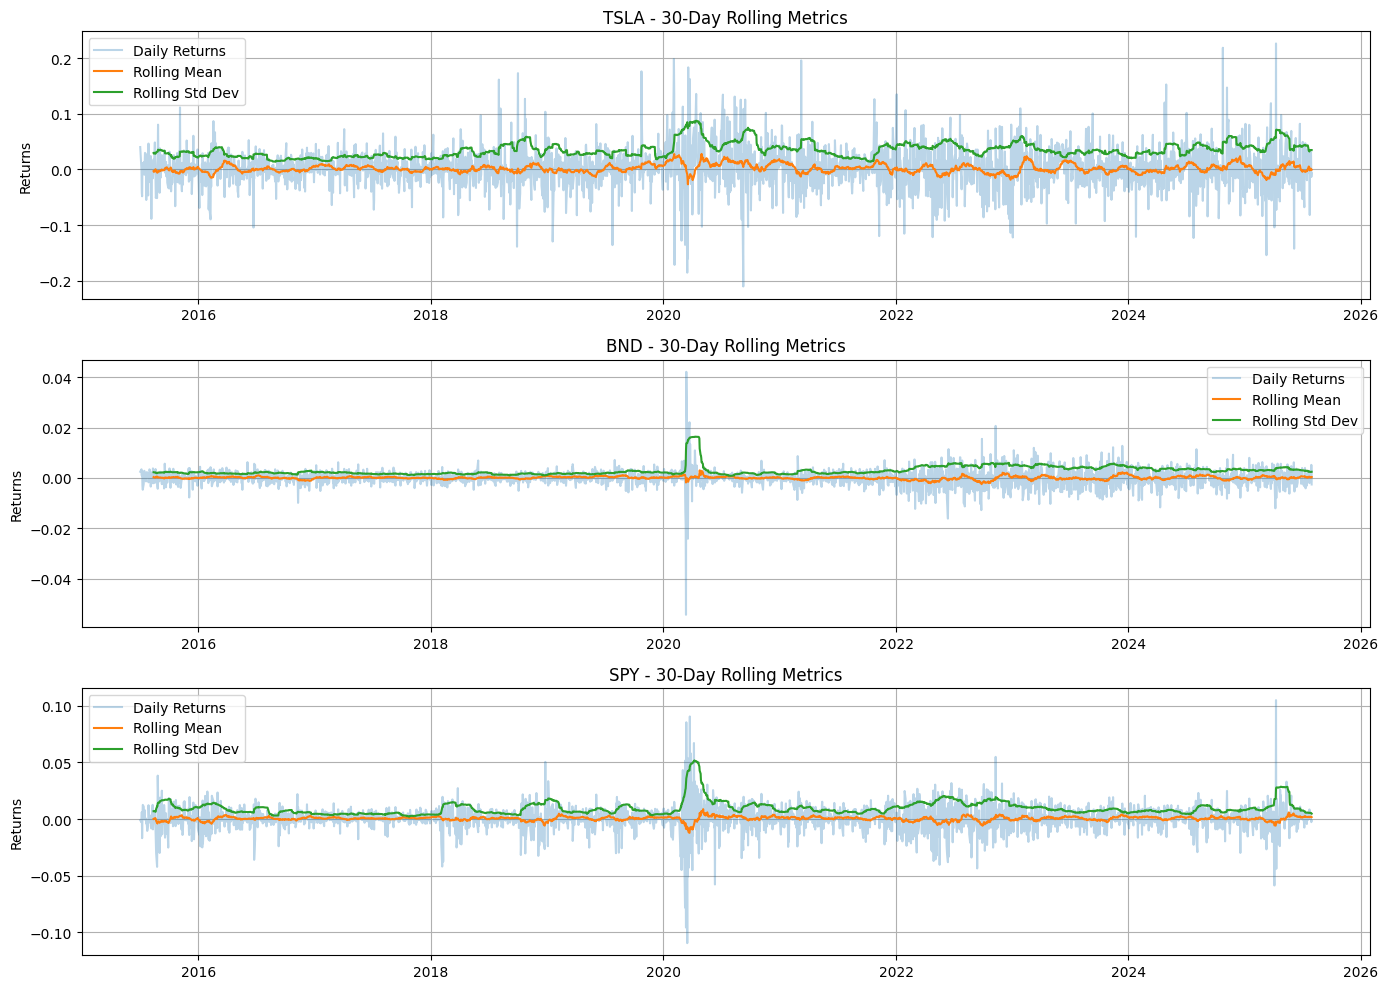

In [9]:
# Calculate rolling metrics (30-day window)
rolling_window = 30

plt.figure(figsize=(14, 10))

for i, ticker in enumerate(tickers, 1):
    plt.subplot(3, 1, i)
    
    # Rolling mean and std
    rolling_mean = daily_returns[ticker].rolling(rolling_window).mean()
    rolling_std = daily_returns[ticker].rolling(rolling_window).std()
    
    plt.plot(daily_returns[ticker], alpha=0.3, label='Daily Returns')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std Dev')
    
    plt.title(f'{ticker} - 30-Day Rolling Metrics')
    plt.ylabel('Returns')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Outlier Detection

In [10]:
# Identify days with extreme returns (outside 3 standard deviations)
for ticker in tickers:
    mean_return = daily_returns[ticker].mean()
    std_return = daily_returns[ticker].std()
    
    outliers = daily_returns[(daily_returns[ticker] > mean_return + 3*std_return) | 
                             (daily_returns[ticker] < mean_return - 3*std_return)]
    
    print(f"\n{ticker} - Extreme Return Days (>3σ):")
    print(outliers[[ticker]].sort_values(by=ticker, ascending=False))


TSLA - Extreme Return Days (>3σ):
Ticker          TSLA
Date                
2025-04-09  0.226900
2024-10-24  0.219190
2020-02-03  0.198949
2021-03-09  0.196412
2020-03-19  0.183877
2019-10-24  0.176692
2018-10-01  0.173471
2020-03-24  0.162817
2018-08-02  0.161880
2024-04-29  0.153069
2024-11-06  0.147510
2020-02-04  0.137256
2020-04-13  0.136038
2022-01-03  0.135317
2020-07-06  0.134794
2020-08-12  0.131236
2018-10-23  0.127189
2021-10-25  0.126616
2020-09-14  0.125832
2020-08-31  0.125689
2024-04-24  0.120611
2025-03-24  0.119336
2022-12-27 -0.114089
2022-01-27 -0.115542
2020-03-12 -0.116172
2021-11-09 -0.119903
2024-01-25 -0.121253
2022-04-26 -0.121841
2023-01-03 -0.122422
2024-07-24 -0.123346
2020-02-27 -0.128146
2019-01-18 -0.129711
2020-03-09 -0.135725
2019-07-25 -0.136137
2018-09-28 -0.139015
2025-06-05 -0.142599
2025-03-10 -0.154262
2020-03-18 -0.160344
2020-02-05 -0.171758
2020-03-16 -0.185778
2020-09-08 -0.210628

BND - Extreme Return Days (>3σ):
Ticker           BND
Date   

4. Stationarity and Seasonality Analysis

Augmented Dickey-Fuller Test

In [11]:
# Perform ADF test on closing prices and returns
for ticker in tickers:
    print(f"\n{ticker} Stationarity Test:")
    
    # Test for closing prices
    result = adfuller(closing_prices[ticker].dropna())
    print('Closing Prices:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    # Test for returns
    result = adfuller(daily_returns[ticker].dropna())
    print('\nDaily Returns:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')


TSLA Stationarity Test:
Closing Prices:
ADF Statistic: -1.4188720053968273
p-value: 0.5731959514207222
Critical Values:
   1%: -3.4329610922579095
   5%: -2.8626935681060375
   10%: -2.567384088736619

Daily Returns:
ADF Statistic: -34.68109047254185
p-value: 0.0
Critical Values:
   1%: -3.4329352851231945
   5%: -2.862682171580326
   10%: -2.5673780210899224

BND Stationarity Test:
Closing Prices:
ADF Statistic: -1.5362456742625246
p-value: 0.5155110514043479
Critical Values:
   1%: -3.432946577138947
   5%: -2.8626871581881708
   10%: -2.5673806760176046

Daily Returns:
ADF Statistic: -9.88979224572446
p-value: 3.583222858805021e-17
Critical Values:
   1%: -3.4329579682301254
   5%: -2.8626921885291017
   10%: -2.5673833542324727

SPY Stationarity Test:
Closing Prices:
ADF Statistic: 0.6908131739615032
p-value: 0.9896527362932773
Critical Values:
   1%: -3.4329424595562963
   5%: -2.862685339846278
   10%: -2.5673797079109892

Daily Returns:
ADF Statistic: -16.264385090669823
p-valu

Seasonality Analysis

C:\Users\user\AppData\Local\Temp\ipykernel_19888\3887000229.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = daily_returns[ticker].resample('M').mean()


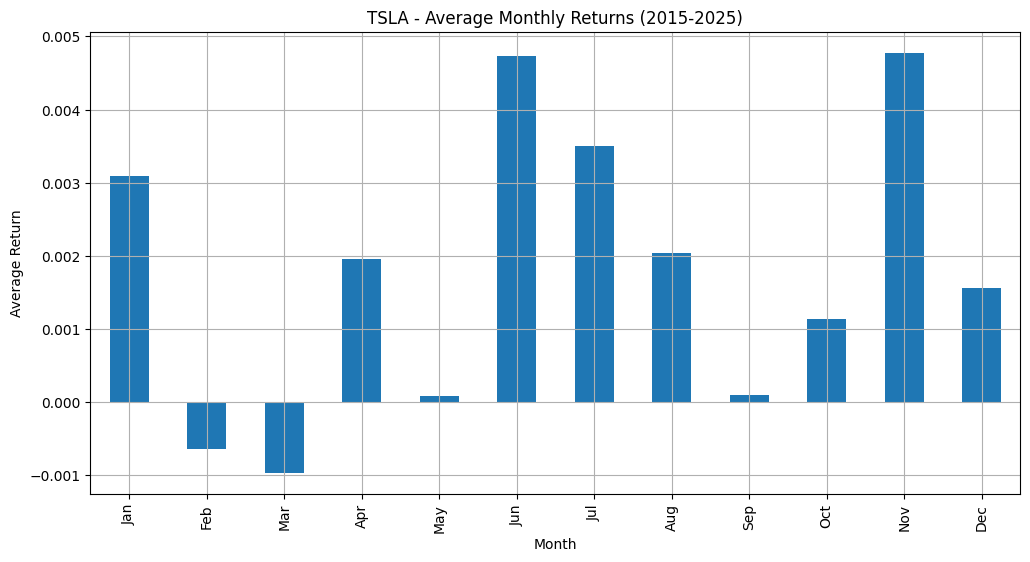

C:\Users\user\AppData\Local\Temp\ipykernel_19888\3887000229.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = daily_returns[ticker].resample('M').mean()


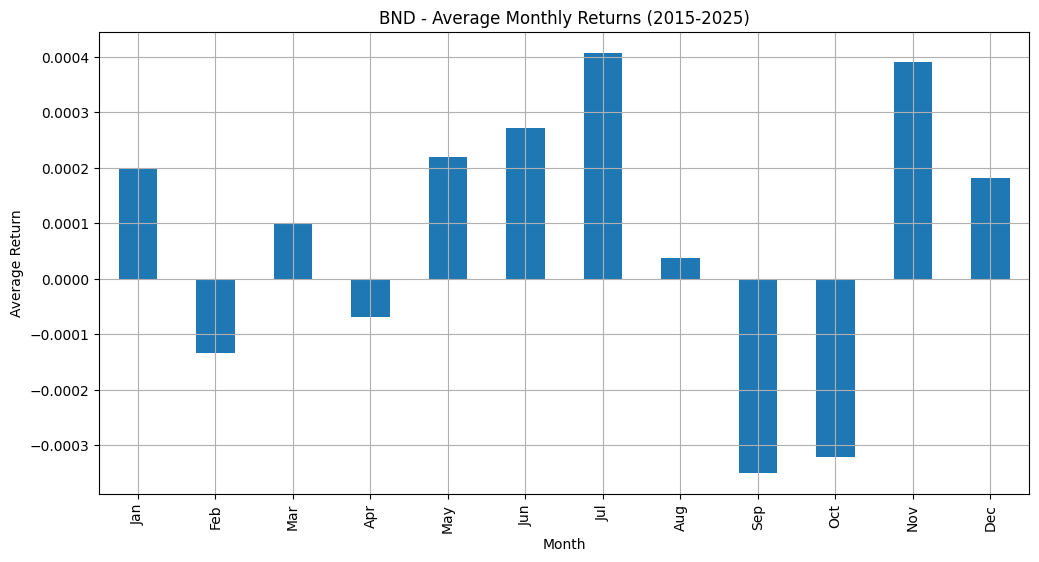

C:\Users\user\AppData\Local\Temp\ipykernel_19888\3887000229.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = daily_returns[ticker].resample('M').mean()


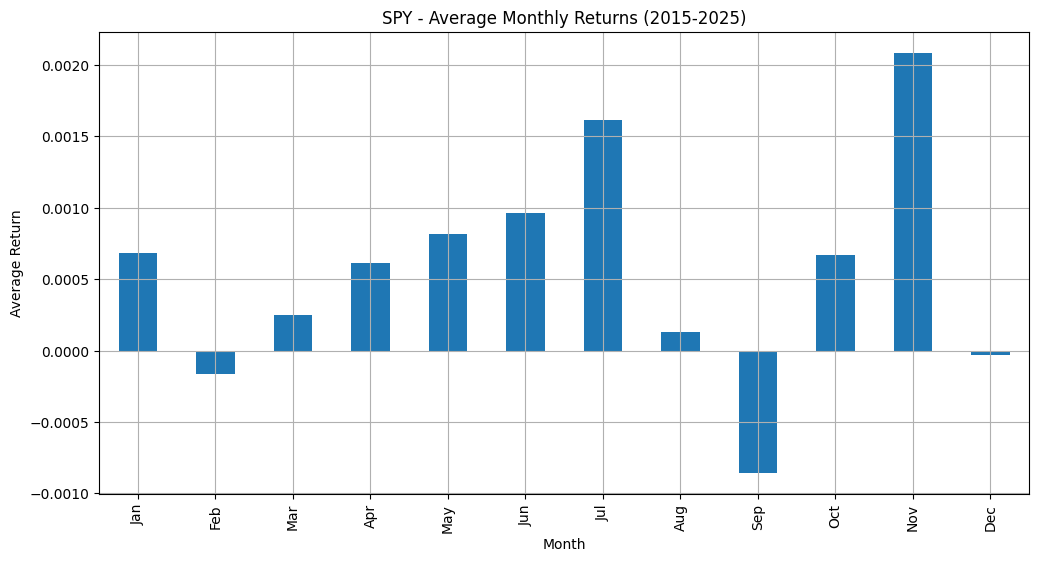

In [12]:
# Monthly average returns
for ticker in tickers:
    monthly_returns = daily_returns[ticker].resample('M').mean()
    
    plt.figure(figsize=(12, 6))
    monthly_returns.groupby(monthly_returns.index.month).mean().plot(kind='bar')
    plt.title(f'{ticker} - Average Monthly Returns (2015-2025)')
    plt.xlabel('Month')
    plt.ylabel('Average Return')
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True)
    plt.show()

5. Risk Metrics Calculation

Value at Risk (VaR)

In [13]:
from scipy.stats import norm

# Calculate VaR at 95% confidence level
confidence_level = 0.95

for ticker in tickers:
    returns = daily_returns[ticker].dropna()
    var_hist = np.percentile(returns, (1 - confidence_level) * 100)
    var_normal = norm.ppf(1 - confidence_level, returns.mean(), returns.std())
    
    print(f"\n{ticker} Value at Risk (95% confidence):")
    print(f"Historical VaR: {var_hist:.4f}")
    print(f"Parametric Normal VaR: {var_normal:.4f}")


TSLA Value at Risk (95% confidence):
Historical VaR: -0.0547
Parametric Normal VaR: -0.0595

BND Value at Risk (95% confidence):
Historical VaR: -0.0049
Parametric Normal VaR: -0.0056

SPY Value at Risk (95% confidence):
Historical VaR: -0.0172
Parametric Normal VaR: -0.0183


Sharpe Ratio

In [14]:
# Assume risk-free rate (annualized) of 2%
risk_free_rate = 0.02 / 252  # Daily rate

for ticker in tickers:
    returns = daily_returns[ticker].dropna()
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    
    print(f"\n{ticker} Sharpe Ratio (annualized): {sharpe_ratio:.4f}")


TSLA Sharpe Ratio (annualized): 0.7446

BND Sharpe Ratio (annualized): -0.0073

SPY Sharpe Ratio (annualized): 0.6844


6. Correlation Analysis

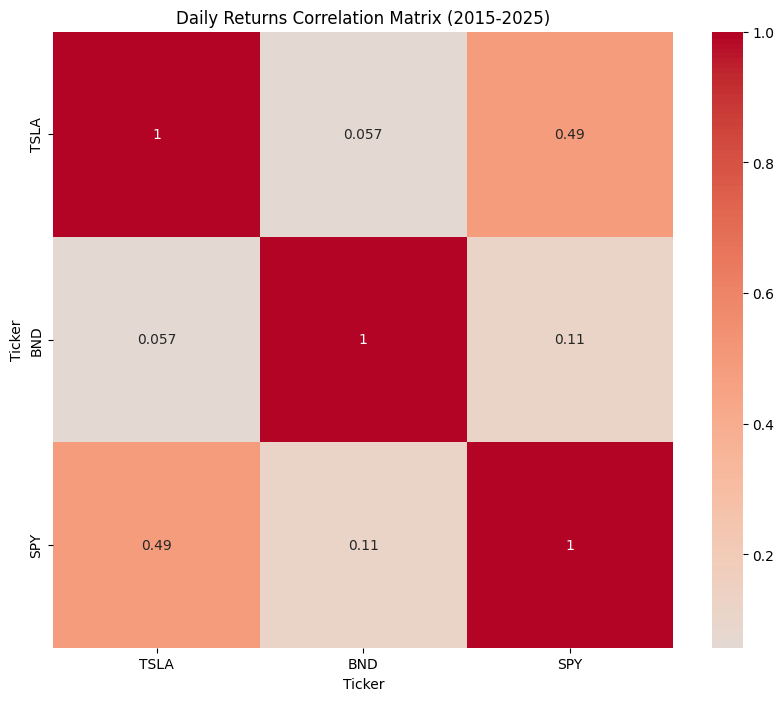

In [16]:
import seaborn as sns
# Calculate correlations between assets
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Daily Returns Correlation Matrix (2015-2025)')
plt.show()